# Transitions Notebook 

In [1]:
import cProfile
import sys
import itertools

import numpy as np
import pandas as pd
import scipy.signal
from scipy.signal import savgol_filter
from scipy.stats import zscore

from tqdm import tqdm

import neuroseries as nts


import time
import matplotlib.pyplot as plt
# %matplotlib qt

import seaborn as sns
import bk.load
import bk.compute
import bk.plot

import os


In [2]:
import matplotlib as mpl
mpl.rcParams["svg.fonttype"] = "none"


# Utils Functions

In [3]:
def plot_loghist(x, bins):
    hist, bins = np.histogram(x, bins=bins)
    logbins = np.logspace(np.log10(bins[0]), np.log10(bins[-1]), len(bins))
    plt.hist(x, bins=logbins)
    plt.xscale("log")


In [4]:
def transition(states, template, epsilon=0):
    """
    author: BK
    states : dict of nts.Interval_set
    template : list of state.
    epsilon : int, will drop any 
     in which there is an epoch shorter than epsilon 's'
    This function will find transition that match the template 
    """
    if epsilon is list:
        print("eplist")
    long = pd.DataFrame()
    for s, i in states.items():
        i["state"] = s
        long = pd.concat((i, long))
        del i["state"]
    order = np.argsort(long.start)
    long = long.iloc[order]

    transition_times = []
    transition_intervals = []
    for i, s in enumerate(long.state):
        tmp = list(long.state[i: i + len(template)])
        if tmp == template:
            tmp_transition = long.iloc[i: i + len(template)]
            #             print(d.iloc[i:i+len(template)])
            length = (tmp_transition.end - tmp_transition.start) / 1_000_000
            if np.any(length.values < epsilon):
                continue
            tmp_pre = np.array(tmp_transition.end[:-1])
            tmp_post = np.array(tmp_transition.start[1:])
            tmp_times = np.mean([tmp_pre, tmp_post], 0)

            transition_intervals.append(
                [tmp_transition.start.iloc[0], tmp_transition.end.iloc[-1]]
            )
            transition_times.append(tmp_times)

    transition_times = np.array(transition_times)
    transition_intervals = np.array(transition_intervals)
    transition_intervals = nts.IntervalSet(
        start=transition_intervals[:, 0],
        end=transition_intervals[:, 1],
        force_no_fix=True,
    )
    return transition_intervals, transition_times


# Computing Activity At Transitions

In [5]:
def compute_transition_activity(neurons, intervals, timing, bin_epochs, n_event):

    transition_activity = []
    for event, t in zip(intervals.iloc, timing):  # For each transitions
        if n_event == 2:
            epochs = np.array(
                [(event.start, t[0]), (t[0], event.end)], dtype=np.int64)
        if n_event == 3:
            epochs = np.array(
                [[event.start, t[0]], [t[0], t[1]], [t[1], event.end]])
        epochs = nts.IntervalSet(start=epochs[:, 0], end=epochs[:, 1])
        # Creates intervals for each state of the transitions events.

        #         binned = np.array(shape = (252,np.sum(bin_epochs)))
        #         binned = np.empty(shape = (252,np.sum(bin_epochs),len(intervals)+1))
        binned = np.empty(shape=(len(neurons), 1))
        for i, epoch in enumerate(epochs.as_units("s").iloc):
            start = epoch.start
            end = epoch.end
            nbins = bin_epochs[i]
            _, b = bk.compute.binSpikes(
                neurons, start=start, stop=end, nbins=nbins)
            b = b / ((end - start) / nbins)  # Converting to firing rates
            binned = np.hstack((binned, b))
        binned = binned[:, 1:]
        transition_activity.append(binned)

    transition_activity = np.array(transition_activity)
    transition_activity = np.moveaxis(transition_activity, 0, 2)

    return transition_activity


def main(base_folder = '/mnt/icybox', local_path="Rat08/Rat08-20130713", *args):
    
    
    # Variables :
    

    plot = False
    save = False

    print(args)
    if args == None:
        transition_interest = [
            ["Rem", "sws", "Rem"]
        ]  # Template of transitions to follow.
        bin_epochs = [12, 30, 12]
        n_event = 3
    else:
        transition_interest = [args[0]]
        bin_epochs = args[1]
        n_event = args[2]

    bk.load.current_session_linux(
        base_folder=base_folder, local_path=local_path)
    neurons, metadata = bk.load.loadSpikeData(bk.load.path)
    states = bk.load.states()

    for i, transition_name in enumerate(
        transition_interest
    ):  # For each kind of transitions
        print(f"Computing {transition_name} transitions")
        intervals, timing = transition(
            states, transition_name, epsilon=50
        )  # Find the timing of the transitions
        print(f"Found {len(intervals)} transitions")

        transition_activity = compute_transition_activity(
            neurons, intervals, timing, bin_epochs, n_event
        )

        if plot:
            print(
                np.mean(transition_activity[metadata.Region == "BLA"], 2).T.shape)
            y_bla = scipy.stats.zscore(
                np.mean(transition_activity[metadata.Region == "BLA"], 2).T, 0
            )
            y_hpc = scipy.stats.zscore(
                np.mean(transition_activity[metadata.Region == "Hpc"], 2).T, 0
            )

            plt.figure()
            plt.plot(y_bla, "green")
            plt.plot(y_hpc, "blue")

            plt.title(f"Rat:{bk.load.rat}, Day{bk.load.day} {bk.load.session}")
        print(os.getcwd())
        # sanity_check(neurons,states,intervals,timing)

        return np.array(transition_activity), metadata, bin_epochs


def NREM_Control(local_path="Rat08/Rat08-20130713", args=None, plot=False, save=False):

    NREM_length = 250
    REM_length = 80 * 1_000_000
    bin_epochs = [30, 12, 30]
    n_events = len(bin_epochs)

    bk.load.current_session_linux(
        base_folder="/mnt/icybox", local_path=local_path)
    neurons, metadata = bk.load.loadSpikeData(bk.load.path)
    states = bk.load.states()

    intervals, _ = transition(states, ["sws"], NREM_length)
    m = (intervals.start + intervals.end) / 2
    timing = np.array([m - (REM_length / 2), m + (REM_length / 2)]).T
    print(f"Found {len(intervals)} transitions")

    transition_activity = compute_transition_activity(
        neurons, intervals, timing, bin_epochs, n_events
    )

    # # sanity_check(neurons,states,intervals,timing)

    return np.array(transition_activity), metadata, bin_epochs


# Not Normalized time

# Merging After Batch

In [6]:
def merge(batch, name, discard):
    transitions_activity = []
    metadata = []
    n_transitions = 0
    n_sessions = 0
    for i, b in batch.items():
        if i not in discard:
            #          if True:
            transitions_activity.append(np.mean(b[0], 2))
            metadata.append(b[1])
            n_transitions += b[0].shape[2]
            n_sessions += 1
            bins_epochs = b[2]

    s = np.append(0, np.cumsum(bins_epochs))[:-1]
    e = np.cumsum(bins_epochs)-1

    intervals = np.array([s, e]).T
    merged = {'name': name,
              'average_transition': np.vstack(transitions_activity),
              'metadata': pd.concat(metadata),
              'n_transitions': n_transitions,
              'n_sessions': n_sessions,
              'intervals': intervals}

    merged['metadata'].Type[merged['metadata'].Region == 'CeCM'] = 'Int'
    return merged


In [7]:
discard = [
    "Rat08-20130718",
    "Rat09-20140408",
    "Rat09-20140409",
    "Rat10-20140619",
    "Rat10-20140620",
    "Rat10-20140622",
]


# Plot double transitons and pre vs post

In [8]:
def plot_average_transitions(merged_activity, norm='zscore', ax=None, style='b-'):
    if ax is None:
        fig, ax = plt.subplots(1, 1)
    if norm == 'zscore':
        merged_activity = zscore(merged_activity, 1)
    ax.plot(np.nanmean(merged_activity, 0), style)


def plot_violin_pre_post(merged_activity, pre, post, title, norm='zscore', ax=None, ylim=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1)
    if norm == 'zscore':
        merged_activity = zscore(merged_activity, 1)

    # Parse data in df :

    activity = {'pre': np.nanmean(merged_activity[:, pre[0]:pre[1]], 1),
                'post': np.nanmean(merged_activity[:, post[0]:post[1]], 1)}

    if norm != 'zscore':
        not_zeros = (activity['pre'] != 0) & (activity['post'] != 0)
        activity['pre'] = np.log10(activity['pre'][not_zeros])
        activity['post'] = np.log10(activity['post'][not_zeros])
        ax.set_ylabel('Log(FR) ')

    a = np.array([activity['pre'], activity['post']]).T
    df = pd.DataFrame(a, columns=['Pre', 'Post'])
    plt.sca(ax)
    sns.violinplot(data=df)
    if ylim is not None:
        ax.set_ylim(ylim)
    plt.title(title)


def make_figure(merged, stru, norm='zscore', ylimL=None, ylimR=None, ylim_violin=None, **kwargs):

    name = merged['name']
    average_transition = merged['average_transition']
    intervals = merged['intervals']
    metadata = merged['metadata']

    if 'intervals_colors' in kwargs:
        intervals_colors = kwargs['intervals_colors']
    else:
        intervals_colors = ['grey'] * len(intervals)

    fig, ax = plt.subplot_mosaic("""
                                  AB
                                  AC
                                 """,
                                 dpi=180)
    stru_pyr_average = average_transition[(metadata['Region'] == stru)
                                          & (metadata['Type'] == 'Pyr')]
    stru_int_average = average_transition[(metadata['Region'] == stru)
                                          & (metadata['Type'] == 'Int')]
    if norm == 'zscore':
        plot_average_transitions(
            stru_pyr_average, norm, ax=ax['A'], style='-b')
        plot_average_transitions(
            stru_int_average, norm, ax=ax['A'], style='-k')
        ax['A'].set_ylabel('Firing Rates (zscore)')
        ax['A'].set_xlabel('Normalized Time')
    else:
        plot_average_transitions(
            stru_pyr_average, norm, ax=ax['A'], style='-b')
        right = ax['A'].twinx()
        plot_average_transitions(stru_int_average, norm, ax=right, style='-k')
        ax['A'].set_ylabel('Firing Rates (Hz)')
        ax['A'].set_xlabel('Normalized Time')

    if ylimL is not None:
        ax['A'].set_ylim(ylimL[0], ylimL[1])
    if ylimR is not None:
        right.set_ylim(ylimR[0], ylimR[1])

    for n, (s, e) in enumerate(intervals):
        ax['A'].axvspan(s, e, color=intervals_colors[n])

    pre = [intervals[0, 0], intervals[0, 1]]
    post = [intervals[-1, 0], intervals[-1, 1]]
    plot_violin_pre_post(stru_pyr_average, pre, post, 'Pyr',
                         norm, ax=ax['B'], ylim=ylim_violin)
    plot_violin_pre_post(stru_int_average, pre, post, 'Int',
                         norm, ax=ax['C'], ylim=ylim_violin)

    ax['A'].set_title((f'{name}'))
    plt.suptitle(stru)
    plt.tight_layout()
    return 0


def make_quantile_figure():
    name = merged['name']
    average_transition = merged['average_transition']
    intervals = merged['intervals']
    metadata = merged['metadata']



In [9]:
def make_figure_oscillation(merged, stru, norm='zscore', ylimL=None, ylimR=None, ylim_violin=None, **kwargs):
    '''
    On going, but got some problem. Metadata is not same len in both situations ... it is such a pain arzejkljrhkler
    '''
    name = merged['name']
    average_transition = merged['average_transition']
    intervals = merged['intervals']
    metadata = merged['metadata']

    if 'intervals_colors' in kwargs:
        intervals_colors = kwargs['intervals_colors']
    else:
        intervals_colors = ['grey'] * len(intervals)

    fig, ax = plt.subplot_mosaic("""
                                  AB
                                  AC
                                 """,
                                 dpi=180)
    stru_pyr_average = average_transition[(metadata['Region'] == stru)
                                          & (metadata['Type'] == 'Pyr')]
    stru_int_average = average_transition[(metadata['Region'] == stru)
                                          & (metadata['Type'] == 'Int')]
    if norm == 'zscore':
        plot_average_transitions(
            stru_pyr_average, norm, ax=ax['A'], style='-b')
        plot_average_transitions(
            stru_int_average, norm, ax=ax['A'], style='-k')
        ax['A'].set_ylabel('Firing Rates (zscore)')
        ax['A'].set_xlabel('Normalized Time')
    else:
        plot_average_transitions(
            stru_pyr_average, norm, ax=ax['A'], style='-b')
        right = ax['A'].twinx()
        plot_average_transitions(stru_int_average, norm, ax=right, style='-k')
        ax['A'].set_ylabel('Firing Rates (Hz)')
        ax['A'].set_xlabel('Normalized Time')

    if ylimL is not None:
        ax['A'].set_ylim(ylimL[0], ylimL[1])
    if ylimR is not None:
        right.set_ylim(ylimR[0], ylimR[1])

    for n, (s, e) in enumerate(intervals):
        ax['A'].axvspan(s, e, color=intervals_colors[n])

    pre = [intervals[0, 0], intervals[0, 1]]
    post = [intervals[-1, 0], intervals[-1, 1]]
    plot_violin_pre_post(stru_pyr_average, pre, post, 'Pyr',
                         norm, ax=ax['B'], ylim=ylim_violin)
    plot_violin_pre_post(stru_int_average, pre, post, 'Int',
                         norm, ax=ax['C'], ylim=ylim_violin)

    ax['A'].set_title((f'{name}'))
    plt.suptitle(stru)
    plt.tight_layout()
    return 0

In [10]:
def get_numbers(merged,stru):
    filt_stru = merged['metadata']['Region'] == stru
    filt_pyr = (merged['metadata']['Region'] == stru) * merged['metadata']['Type'] == 'Pyr'
    filt_int = (merged['metadata']['Region'] == stru) * merged['metadata']['Type'] == 'Int'

    n_ses = list(zip(merged['metadata'][filt_stru]['Rat'].values,merged['metadata'][filt_stru]['Day']))
    res = list(dict.fromkeys(n_ses))
    
    n_trans = merged['n_transitions'] 


    print(stru)
    print(f'Number of session = {len(res)}')
    print(f'Number of transitions = {n_trans}')
    print(f'Pyr : {np.sum(filt_pyr)}')
    print(f'Pyr : {np.sum(filt_int)}')
    print('\n')

# Make Statistics

In [11]:
def statistics(merged, stru, pre, post):
    stru_pyr_average = merged['average_transition'][(merged['metadata']['Region'] == stru)
                                                    & (merged['metadata']['Type'] == 'Pyr')]
    stru_int_average = merged['average_transition'][(merged['metadata']['Region'] == stru)
                                                    & (merged['metadata']['Type'] == 'Int')]
    activity = {'pre': np.nanmean(stru_pyr_average[:, pre[0]:pre[1]], 1),
                'post': np.nanmean(stru_pyr_average[:, post[0]:post[1]], 1)}

    _, p_pyr = scipy.stats.wilcoxon(activity['pre'], activity['post'])

    activity = {'pre': np.nanmean(stru_int_average[:, pre[0]:pre[1]], 1),
                'post': np.nanmean(stru_int_average[:, post[0]:post[1]], 1)}

    _, p_int = scipy.stats.wilcoxon(activity['pre'], activity['post'])

    return p_pyr, p_int


# REM_NREM

In [12]:
get_numbers(m_NREM_REM,'BLA')

NameError: name 'm_NREM_REM' is not defined

In [77]:
args = [["Rem", "sws"], [12, 30], 2]
# REM_NREM = bk.load.batch(main, *args)
m_REM_NREM = merge(REM_NREM, 'REM_NREM', discard)
# make_figure(m_REM_NREM,'BLA',norm = 'no',intervals_colors = ['orange','grey'],ylimL=yLimPyr,ylimR=yLimInt)


# NREM_REM

In [14]:
yLimPyr = [0,3]
yLimInt = [10,13]


0

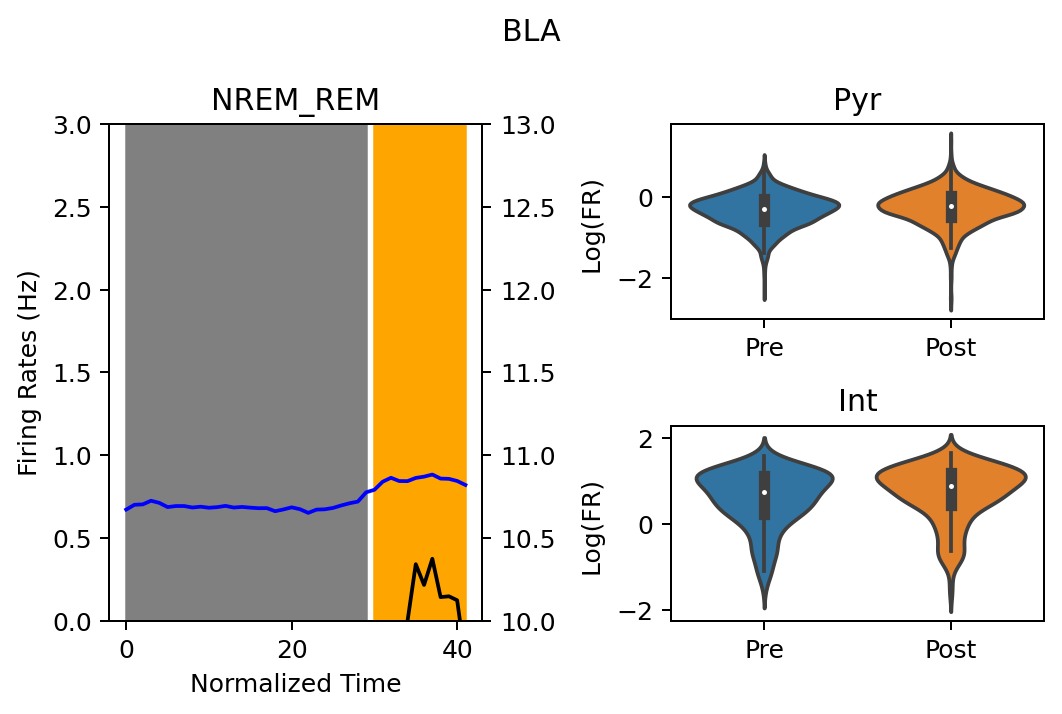

In [15]:
args = [["sws", "Rem"], [30, 12], 2]
# NREM_REM = bk.load.batch(main, *args)
m_NREM_REM = merge(NREM_REM, 'NREM_REM', discard)
make_figure(m_NREM_REM,'BLA',norm = 'no',intervals_colors = ['grey','orange'],ylimL=yLimPyr,ylimR=yLimInt)


# NREM_REM_NREM

In [27]:
args = [["sws", "Rem", "sws"], [30, 12, 30], 3]
# NREM_REM_NREM = bk.load.batch(main, *args)
m_NREM_REM_NREM = merge(NREM_REM_NREM, "NREM_REM_NREM", discard)
# make_figure(m_NREM_REM_NREM,'BLA','no',intervals_colors = ['grey','orange','grey'],ylimL=yLimPyr,ylimR=yLimInt)
for s in ['Hpc','BLA']:
    get_numbers(m_NREM_REM_NREM,s)

Hpc
Number of session = 29
Number of transitions = 113
Pyr : 712
Pyr : 96


BLA
Number of session = 24
Number of transitions = 113
Pyr : 1081
Pyr : 168




# REM_NREM_REM

In [28]:
arg = [["Rem", "sws", "Rem"], [12, 30, 12], 3]
# REM_NREM_REM = bk.load.batch(main, *arg)
m_REM_NREM_REM = merge(REM_NREM_REM, "REM_NREM_REM", discard)
# make_figure(m_REM_NREM_REM,'BLA','no',intervals_colors = ['orange','grey','orange'],ylimL=yLimPyr,ylimR=yLimInt)
for s in ['Hpc','BLA']:
    get_numbers(m_REM_NREM_REM,s)

Hpc
Number of session = 19
Number of transitions = 42
Pyr : 395
Pyr : 58


BLA
Number of session = 16
Number of transitions = 42
Pyr : 844
Pyr : 132




In [15]:
get_numbers(m_REM_NREM_REM,'BLA')

Number of session = 16
Pyr : 844
Pyr : 132


# NREM_Control : 

In [14]:
arg = [None]
NREM = bk.load.batch(NREM_Control, arg, verbose=False, linux=True)
m_NREM = merge(NREM, "NREM", discard)
# make_figure(m_NREM,'BLA','no',ylimL=yLimPyr,ylimR=yLimInt)


100%|██████████| 61/61 [01:43<00:00,  1.69s/it]


Batch finished in 103.36374115943909
Some session were not processed correctly
['Rat08-20130720', 'Rat08-20130722', 'Rat11-20150401']
4.918032786885246 %


## Make figures if all computation went fine

In [18]:
# CONSTANTES :
yLimPyr = [0, 2]
# yLimPyr = [-1.2,1.2]
yLimInt = [0, 16]
ylim_violin = [-3, 3]


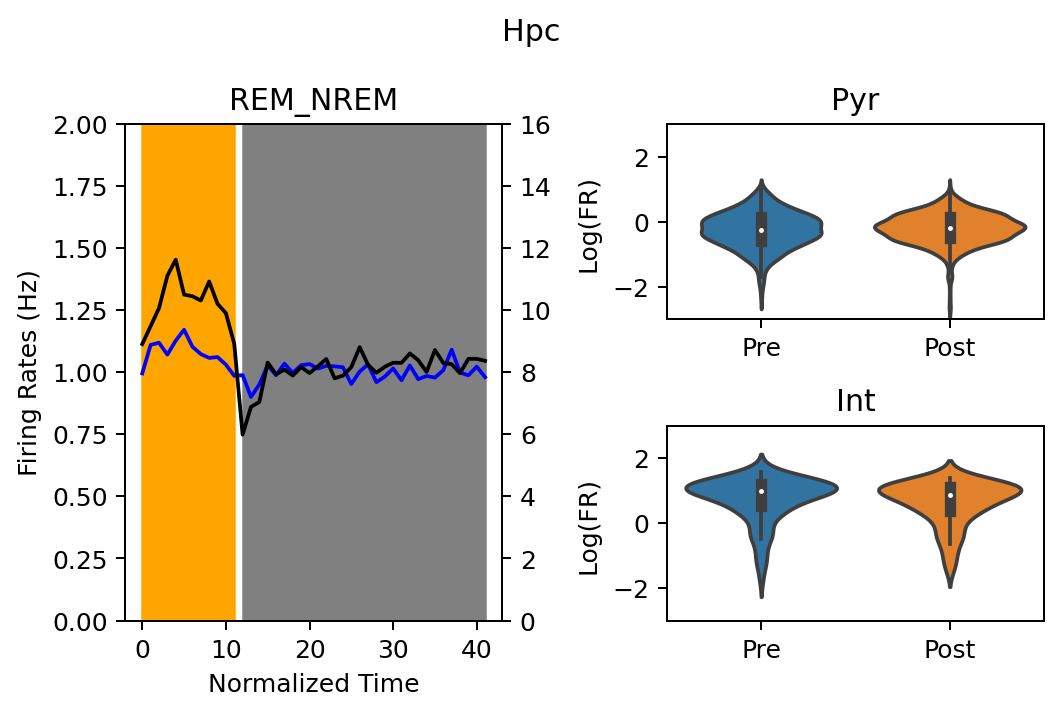

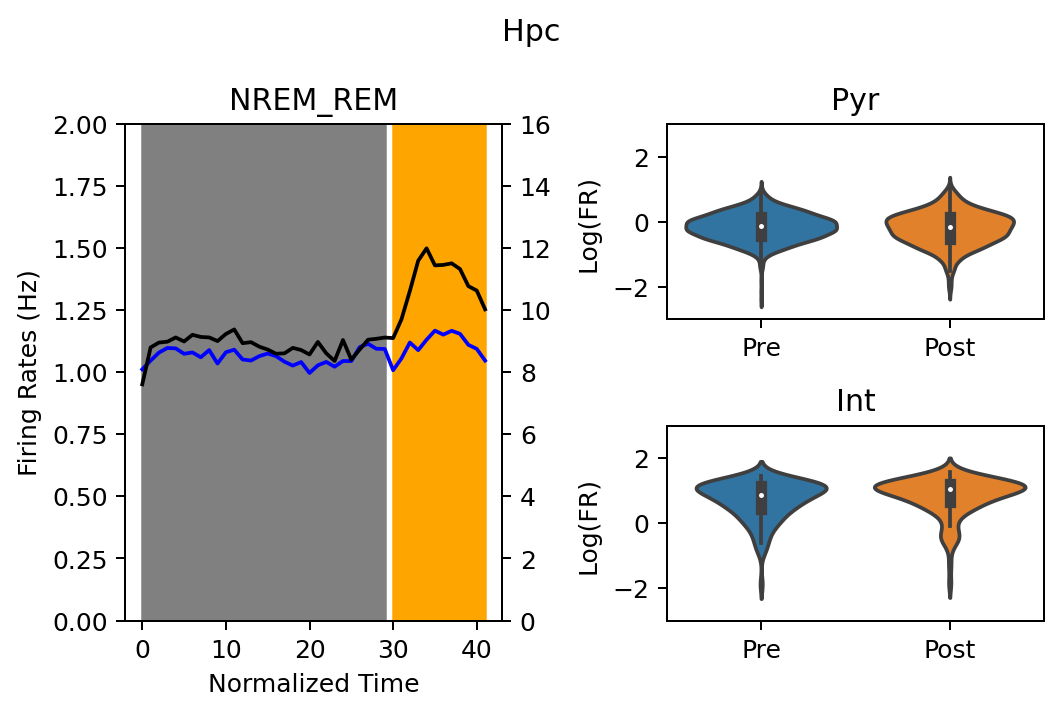

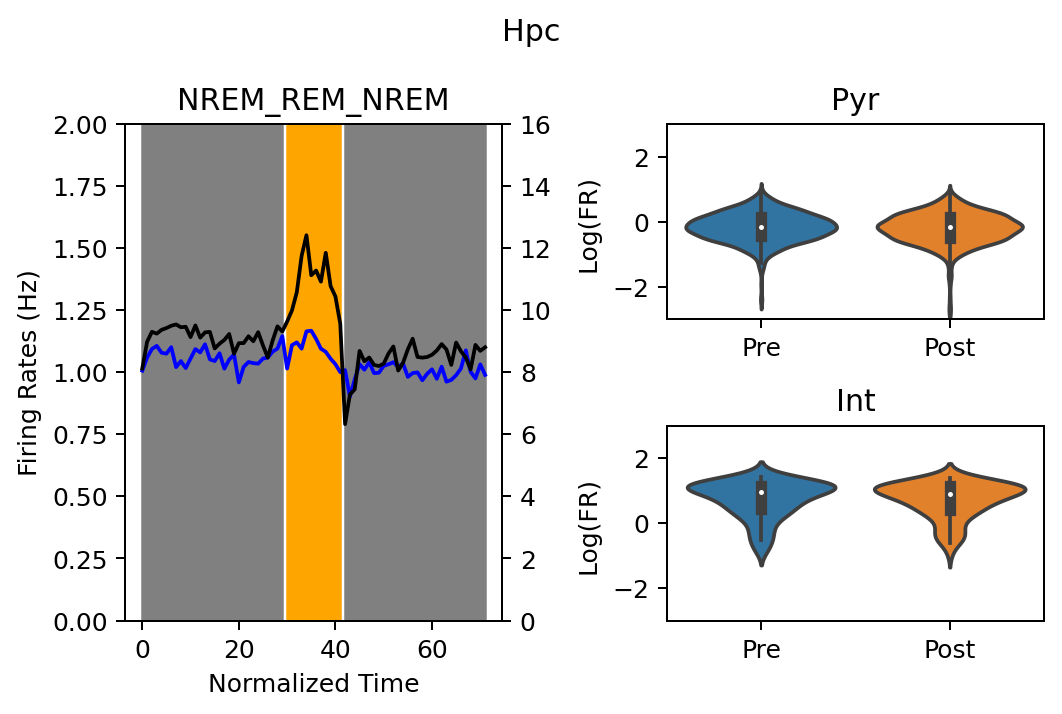

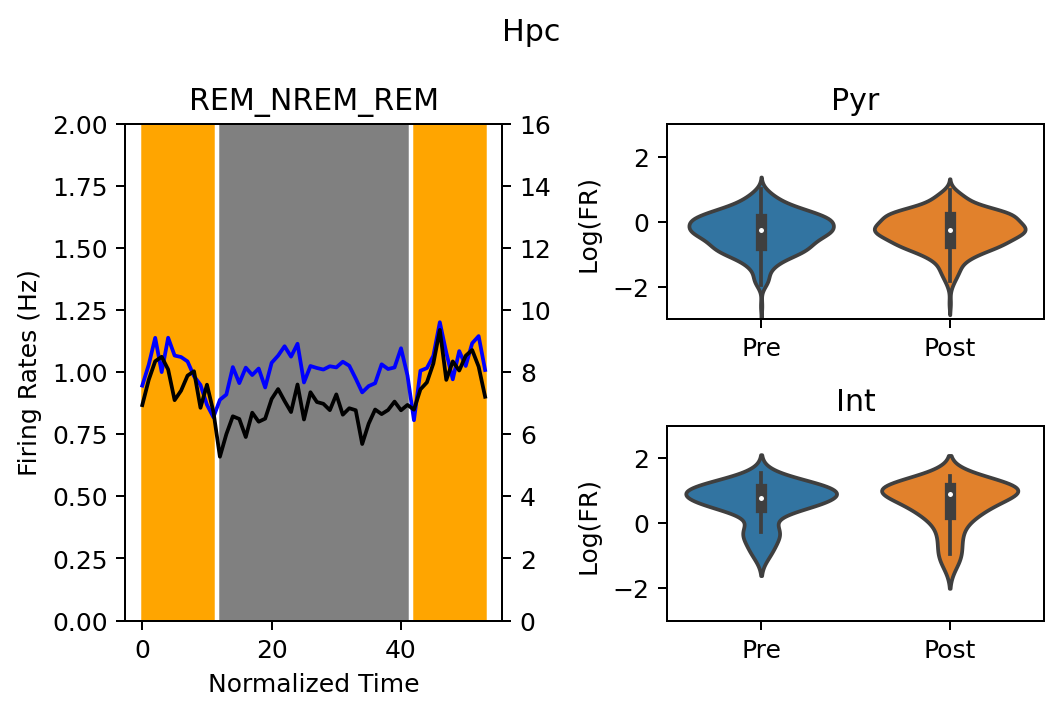

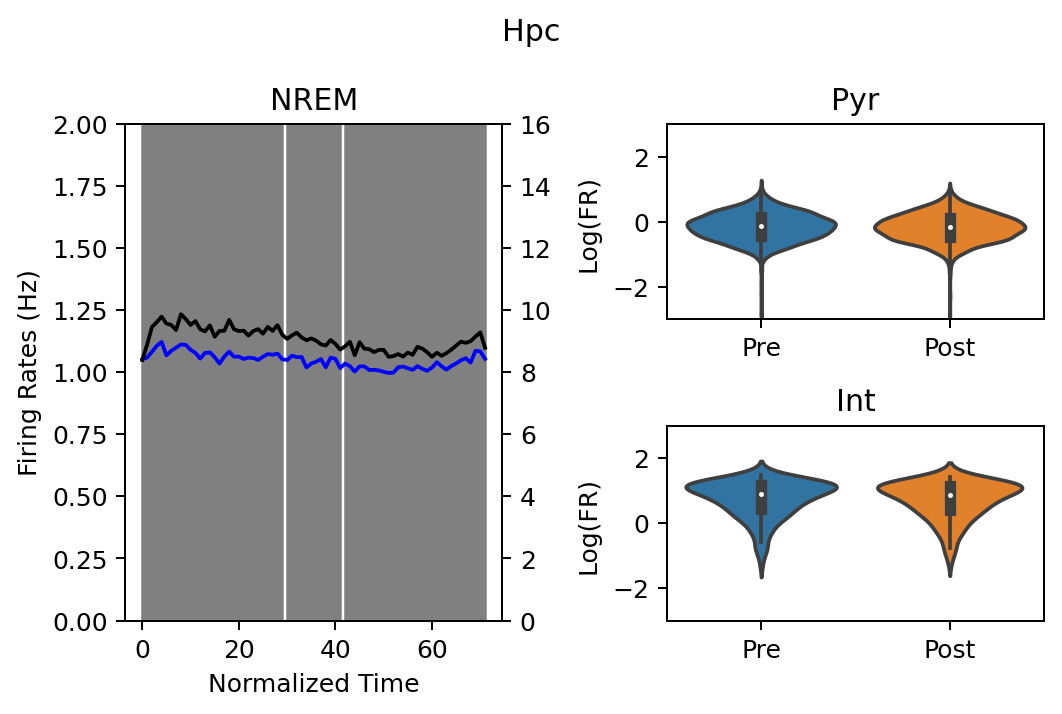

In [70]:
stru = 'Hpc'
norm = 'FR'
merged_data = {'REM_NREM': [m_REM_NREM, ['orange', 'grey']],
               'NREM_REM': [m_NREM_REM, ['grey', 'orange']],
               'NREM_REM_NREM': [m_NREM_REM_NREM, ['grey', 'orange', 'grey']],
               'REM_NREM_REM': [m_REM_NREM_REM, ['orange', 'grey', 'orange']],
               'NREM_Control': [m_NREM, ['grey', 'grey', 'grey']]}


for name, data in merged_data.items():
    save_directory = '/home/billel/pCloudDrive/IFM/work/Figures_Gabrielle/Transitions/'
    save_path = os.path.join(save_directory, f'{norm}/{stru}/')
    save_name = f'{name}.svg'
    make_figure(data[0], stru, norm, ylimL=yLimPyr, ylimR=yLimInt,
                ylim_violin=ylim_violin, intervals_colors=data[1])
    if not os.path.exists(save_path):
        os.makedirs(save_path)

    plt.savefig(os.path.join(save_path, save_name))


In [51]:
print('                   Pyramidaux', '              Interneurons')
print('NREM_REM_NREM', statistics(m_NREM_REM_NREM, 'BLA', [0, 29], [42, 71]))
print('NREM', statistics(m_NREM, 'BLA', [0, 29], [42, 71]))
print('REM_NREM_REM', statistics(m_REM_NREM_REM, 'BLA', [0, 11], [42, 54]))


                   Pyramidaux               Interneurons
NREM_REM_NREM (2.085354728776074e-22, 1.9055085023107943e-09)
NREM (1.0238766150151973e-12, 3.6594455439511954e-17)
REM_NREM_REM (0.12955584965911915, 0.25897202901398186)


/tmp/ipykernel_38586/1633741778.py:38: RuntimeWarning: divide by zero encountered in true_divide
  np.nanmean((average_stru_pyr.T / mean_pyr_last_third).T, 0) * 100
/tmp/ipykernel_38586/1633741778.py:38: RuntimeWarning: invalid value encountered in true_divide
  np.nanmean((average_stru_pyr.T / mean_pyr_last_third).T, 0) * 100
/tmp/ipykernel_38586/1633741778.py:41: RuntimeWarning: divide by zero encountered in true_divide
  np.nanmean((average_stru_int.T / mean_int_last_third).T, 0) * 100
/tmp/ipykernel_38586/1633741778.py:41: RuntimeWarning: invalid value encountered in true_divide
  np.nanmean((average_stru_int.T / mean_int_last_third).T, 0) * 100


(42,)
(42,)


/tmp/ipykernel_38586/1633741778.py:38: RuntimeWarning: divide by zero encountered in true_divide
  np.nanmean((average_stru_pyr.T / mean_pyr_last_third).T, 0) * 100
/tmp/ipykernel_38586/1633741778.py:38: RuntimeWarning: invalid value encountered in true_divide
  np.nanmean((average_stru_pyr.T / mean_pyr_last_third).T, 0) * 100
/tmp/ipykernel_38586/1633741778.py:41: RuntimeWarning: divide by zero encountered in true_divide
  np.nanmean((average_stru_int.T / mean_int_last_third).T, 0) * 100
/tmp/ipykernel_38586/1633741778.py:41: RuntimeWarning: invalid value encountered in true_divide
  np.nanmean((average_stru_int.T / mean_int_last_third).T, 0) * 100


(42,)
(42,)


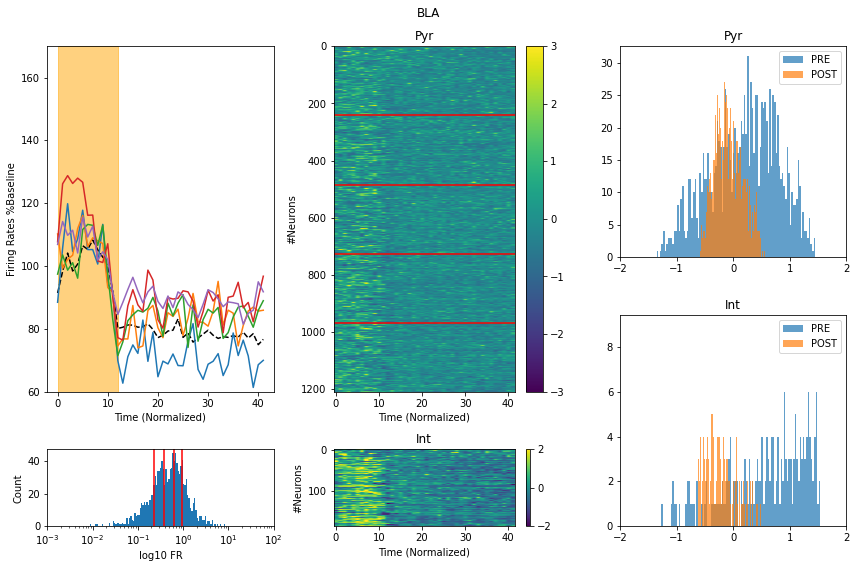

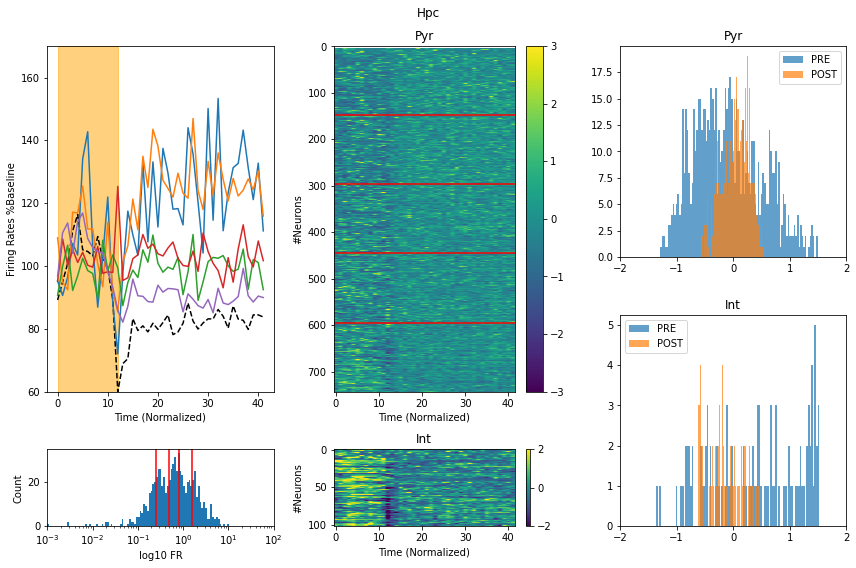

In [86]:
stru = ["Hpc", "BLA", "CeCM", "Pir", "BMA", "BMP", "BLV"]
stru = ["BLA", "Hpc"]
transition = m_REM_NREM
for s in stru:
    fig, ax = plt.subplot_mosaic(
        """
                                   ABD
                                   ABD
                                   ABE
                                   FCE
                                """,
        figsize=[12, 8],
    )
    metadata = m_REM_NREM["metadata"]
    stru_mask = metadata.Region == s
    pyr_mask = metadata.Type == "Pyr"
    int_mask = metadata.Type == "Int"

    average_stru_pyr = m_REM_NREM["average_transition"][stru_mask & pyr_mask]
    average_stru_int = m_REM_NREM["average_transition"][stru_mask & int_mask]

    if s == "CeCM":
        average_stru_pyr = average_stru_int

    z_average_stru_pyr = zscore(average_stru_pyr, 1)
    z_average_stru_int = zscore(average_stru_int, 1)

    #     z_average_stru_pyr = z_average_stru_pyr[~np.isnan(z_average_stru_pyr[:,0])]
    #     z_average_stru_int = z_average_stru_int[~np.isnan(z_average_stru_int[:,0])]

    mean_pyr_fr_sleep = np.nanmean(average_stru_pyr, 1)
    mean_int_fr_sleep = np.nanmean(average_stru_int, 1)

    mean_pyr_last_third = np.nanmean(average_stru_pyr[:, 8:12], 1)
    mean_int_last_third = np.nanmean(average_stru_int[:, 8:12], 1)

    average_baseline_pyr = (
        np.nanmean((average_stru_pyr.T / mean_pyr_last_third).T, 0) * 100
    )
    average_baseline_int = (
        np.nanmean((average_stru_int.T / mean_int_last_third).T, 0) * 100
    )

    order_pyr = np.argsort(mean_pyr_fr_sleep)
    order_int = np.argsort(mean_int_fr_sleep)

    # mean_average_stru_pyr = np.nanmean(average_stru_pyr, 0)
    # norm_mean_average_stru_pyr = (
    #     mean_average_stru_pyr / np.nanmean(mean_average_stru_pyr[8:12]) * 100
    # )

    mean_average_stru_int = np.nanmean(average_stru_int, 0)
    print(mean_average_stru_int.shape)
    norm_mean_average_stru_int = (
        mean_average_stru_int / np.nanmean(mean_average_stru_int[8:12]) * 100
    )
    print(norm_mean_average_stru_int.shape)
    #     ax['A'].plot(np.mean(zscore(average_stru_int,1),0),'--',color = 'black')
    #     ax['A'].plot(average_baseline_int,'--',color = 'black')
    ax["A"].plot(norm_mean_average_stru_int, "--", color="black")
    quantiles = pd.qcut(mean_pyr_fr_sleep, 5)
    for q in quantiles.categories:
        #         average_baseline_pyr = 100*np.nanmean((average_stru_pyrc/mean_pyr_last_third[(mean_pyr_fr_sleep > q.left) & (mean_pyr_fr_sleep< q.right)]).T,0)
        #         ax['A'].plot(np.mean(zscore(average_stru_pyr[(mean_pyr_fr_sleep > q.left) & (mean_pyr_fr_sleep< q.right)],1).T,1))

        mean_average_stru_pyr = np.nanmean(
            average_stru_pyr[
                (mean_pyr_fr_sleep > q.left) & (mean_pyr_fr_sleep < q.right)
            ],
            0,
        )
        norm_mean_average_stru_pyr = (
            mean_average_stru_pyr / np.nanmean(mean_average_stru_pyr[8:12]) * 100
        )

        ax["A"].plot(norm_mean_average_stru_pyr)
        if q.left > 0:
            ax["F"].axvline((q.left), color="red")
    ax["A"].axvspan(0, 12, color="orange", alpha=0.5)
    ax["A"].set_ylim([60, 170])
    ax["A"].set_xlabel("Time (Normalized)")
    ax["A"].set_ylabel("Firing Rates %Baseline")

    #     l = np.log10(mean_pyr_fr_sleep)
    #     l[np.isinf(l)] = np.nan
    #     ax['F'].hist(mean_pyr_fr_sleep,100,log=True)
    #     ax['F'].set_xscale('log')

    #     ax['F'].set_xlim([0.001,100])
    plt.sca(ax["F"])
    plot_loghist(mean_pyr_fr_sleep[mean_pyr_fr_sleep > 0], 100)
    ax["F"].set_xlim([0.001, 100])
    ax["F"].set_xlabel("log10 FR")
    ax["F"].set_ylabel("Count")

    im = ax["B"].imshow(z_average_stru_pyr[order_pyr, :], aspect="auto")
    im.set_clim([-3, 3])
    fig.colorbar(im, ax=ax["B"])
    ax["B"].set_ylabel("#Neurons")
    ax["B"].set_xlabel("Time (Normalized)")
    ax["B"].set_title("Pyr")

    pourcentiles = [0.20, 0.40, 0.60, 0.80]
    for p in pourcentiles:
        ax["B"].axhline(int(p * len(average_stru_pyr)), color="red")

    im = ax["C"].imshow(z_average_stru_int[order_int, :], aspect="auto")
    im.set_clim([-2, 2])
    ax["C"].set_xlabel("Time (Normalized)")
    ax["C"].set_ylabel("#Neurons")
    ax["C"].set_title("Int")
    fig.colorbar(im, ax=ax["C"])

    #     z_average_stru_pyr = zscore(average_stru_pyr,0)

    ### Violin plot
    mean_pre_pyr = np.mean(z_average_stru_pyr[:, 0:12], 1)
    mean_post_pyr = np.mean(z_average_stru_pyr[:, 12:41], 1)

    mean_pre_int = np.nanmean(z_average_stru_int[:, 0:12], 1)
    mean_post_int = np.nanmean(z_average_stru_int[:, 12:41], 1)

    df_pyr = pd.DataFrame(
        (np.array([mean_pre_pyr, mean_post_pyr]).T), columns=["PRE", "POST"]
    )
    df_int = pd.DataFrame(
        (np.array([mean_pre_int, mean_post_int]).T), columns=["PRE", "POST"]
    )
    df_pyr.replace([np.inf, -np.inf], np.nan, inplace=True)
    df_int.replace([np.inf, -np.inf], np.nan, inplace=True)

    plt.sca(ax["D"])
    #     sns.violinplot(data = df_pyr)
    ax["D"].set_xlim([-2, 2])
    plt.hist(df_pyr["PRE"], 100, alpha=0.7)
    plt.hist(df_pyr["POST"], 100, alpha=0.7)
    plt.legend(["PRE", "POST"])
    plt.title("Pyr")

    plt.sca(ax["E"])
    #     sns.violinplot(data = df_int)
    plt.hist(df_int["PRE"], 100, alpha=0.7)
    plt.hist(df_int["POST"], 100, alpha=0.7)
    plt.legend(["PRE", "POST"])
    ax["E"].set_xlim([-2, 2])

    plt.title("Int")

    plt.suptitle(s)
    plt.tight_layout()

    plt.savefig(f'/home/billel/pCloudDrive/IFM/work/Figures_Gabrielle/REM_NREM/REM_NREM_{s}.svg')

In [87]:
get_numbers(m_REM_NREM,'BLA')

Number of session = 26
Pyr : 1210
Pyr : 186


In [88]:
get_numbers(m_REM_NREM,'Hpc')

Number of session = 30
Pyr : 743
Pyr : 102


In [31]:
x = np.arange(0,1,0.1)
y = np.sin(x)

In [47]:
%matplotlib
plt.figure(figsize= (12,8))
for i in range(5):
    plt.plot(x,y)

plt.legend([1,2,3,4,5])

Using matplotlib backend: Qt5Agg


# NON NORMALIZED

In [52]:
def compute_transition_activity_not_normalized(neurons, timing, before, after):
    timing = timing / 1_000_000
    transition_activity = []
    spec = []
    for t in timing:  # For each transitions
        chan = bk.load.random_channel("BLA")
        start = t - before
        stop = t + after
        _, b = bk.compute.binSpikes(neurons, binSize=1, start=start, stop=stop)
        transition_activity.append(b)
        lfp = bk.load.lfp(chan, start, stop)

        f, t, Sxx = scipy.signal.spectrogram(
            lfp.values, 1250, nperseg=5000, noverlap=2500
        )
        spec.append(Sxx)
    plt.figure(figsize=[12, 4])
    plt.pcolormesh(t, f, np.log(np.mean(spec, 0)), shading="gouraud")
    plt.clim([8, 10])
    plt.ylim([0, 20])
    plt.xlim(0, before-1+after)
    plt.title("BLA")

    #     print((np.array(spec).shape))
    transition_activity = np.array(transition_activity)
    transition_activity = np.moveaxis(transition_activity, 0, 2)

    transition_spec = np.array(spec)
    transition_spec = np.moveaxis(transition_spec, 0, 2)

    return transition_activity, [f, t, transition_spec]
    
def main_non_normalized(base_folder,
    local_path="Rat08/Rat08-20130713", *args, plot=True, save=False
):
    print(args)  
    if args:
        pre = args[0]
        post = args[1]

        print(f'Pre set as {pre}s and post set as {post}s')
    
    bk.load.current_session_linux(base_folder = base_folder,local_path=local_path)
    neurons, metadata = bk.load.loadSpikeData(bk.load.path)
    states = bk.load.states()

    transition_name = ["Rem", "sws"]

    print(f"Computing {transition_name} transitions")
    intervals, timing = transition(
        states, transition_name, epsilon=[pre, post]
    )  # Find the timing of the transitions
    print(f"Found {len(intervals)} transitions")

    (
        transition_activity,
        (f, t, transition_spec),
    ) = compute_transition_activity_not_normalized(neurons, timing, pre, post+1)

    if plot:
        #         y_bla_pyr = np.mean(scipy.stats.zscore(np.mean(transition_activity[(metadata.Region == "BLA") & (metadata.Type == 'Pyr')],2).T,0),1)
        #         y_bla_int = np.mean(scipy.stats.zscore(np.mean(transition_activity[(metadata.Region == "BLA") & (metadata.Type == 'Int')],2).T,0),1)
        bla_std = scipy.stats.sem(
            np.mean(
                transition_activity[
                    (metadata.Region == "BLA") & (metadata.Type == "Pyr")
                ],
                2,
            ).T,
            1,
        )
        y_bla_pyr = np.mean(
            np.mean(
                transition_activity[
                    (metadata.Region == "BLA") & (metadata.Type == "Pyr")
                ],
                2,
            ).T,
            1,
        )
        #         y_hpc = np.mean(scipy.stats.zscore(np.mean(transition_activity[metadata.Region == "Hpc"],2).T,0),1)

        plt.figure(figsize=[12, 4])
        #         plt.plot(y_bla_int,'k--')
        plt.plot(y_bla_pyr, "green")
        plt.plot(y_bla_pyr + bla_std, "g--", y_bla_pyr - bla_std, "g--")
        plt.xlim(0, pre-1+post)
        plt.axvspan(pre-1, pre-1+post, color="orange", alpha=0.5)
        #         plt.plot(y_hpc,'blue')

        plt.title(f"Rat:{bk.load.rat}, Day{bk.load.day} {bk.load.session}")
        plt.show()

    return transition_activity, (f, t, transition_spec), metadata

In [53]:
def merge_with_spec(batch,name,discard):
    transitions_activity = []
    transition_spec = []
    metadata = []
    n_transitions = 0
    n_sessions = 0
    for i,b in batch.items():
        if i not in discard:
            transitions_activity.append(np.nanmean(b[0],2))
            metadata.append(b[2])
            transition_spec.append(np.nanmean(b[1][2],2))
            f = b[1][0]
            t = b[1][1]
            n_transitions += b[0].shape[2]
            n_sessions += 1 
    merged = {'name':name,
              'average_transition':np.vstack(transitions_activity),
              'metadata':pd.concat(metadata),
              'average_spec':transition_spec,
              't_spec':t,
              'f_spec':f,
              'n_transitions':n_transitions,
              'n_sessions':n_sessions}
    merged['metadata'].Type[merged['metadata'].Region == 'CeCM'] = 'Int'
    return merged

In [60]:
def plot_average_transition(
    average_transition, metadata, region, types, style, interval,pre,post):
    X = scipy.stats.zscore(
        average_transition[(metadata.Region == region) & (metadata.Type == types)],
        1,
        nan_policy="omit",
    ).T
    y = np.nanmean(X, 1)
    y_std = scipy.stats.sem(X, 1, nan_policy="omit")
    #     y_std = np.nanstd(X,1)
    t = np.linspace(-pre, post, len(y))
    # print(len(y))
    plt.plot(t, y, style)
    plt.plot(t, y + y_std, f"{style}--")
    plt.plot(t, y - y_std, f"{style}--")
    plt.axvspan(interval[0], interval[1], color="orange", alpha=0.5)

def plot_average_spec(t_spec, f_spec, average_spec):
    average_spec = np.log(average_spec)
    plt.pcolormesh(
        t_spec - 30, f_spec, average_spec, shading="gouraud", rasterized=True
    )
    #     plt.imshow(average_spec,aspect='auto',origin='lower')
    plt.ylim(0, 20)
    plt.clim(7, 12)
    plt.ylabel("Freq (Hz)")
    plt.xlabel("Time (s)")

In [33]:
args = [90,30]
NREM_REM_NN = bk.load.batch(main_non_normalized,local_base='/mnt/electrophy/Gabrielle/GG-Dataset-Light/',*args)
m_REM_NREM_NN = merge_with_spec(NREM_REM_NN,'BLA',discard)

100%|██████████| 61/61 [08:46<00:00,  8.63s/it]

Batch finished in 526.559686422348
Some session were not processed correctly
['Rat08-20130718', 'Rat08-20130719', 'Rat08-20130720', 'Rat08-20130722', 'Rat09-20140404', 'Rat09-20140405', 'Rat09-20140407', 'Rat09-20140408', 'Rat09-20140409', 'Rat10-20140705', 'Rat10-20140707', 'Rat10-20140708', 'Rat11-20150310', 'Rat11-20150312', 'Rat11-20150313', 'Rat11-20150314', 'Rat11-20150315', 'Rat11-20150316', 'Rat11-20150317', 'Rat11-20150401', 'Rat11-20150402', 'Rat11-20150403']
36.0655737704918 %


In [56]:
args = [30,90]
REM_NREM_NN = bk.load.batch(main_non_normalized,local_base='/mnt/electrophy/Gabrielle/GG-Dataset-Light/',*args)
m_REM_NREM_NN = merge_with_spec(REM_NREM_NN,'BLA',discard)

100%|██████████| 61/61 [03:57<00:00,  3.90s/it]

Batch finished in 237.6826753616333
Some session were not processed correctly
['Rat08-20130717', 'Rat08-20130718', 'Rat08-20130719', 'Rat08-20130720', 'Rat08-20130722', 'Rat09-20140328', 'Rat09-20140331', 'Rat09-20140401', 'Rat09-20140404', 'Rat09-20140405', 'Rat09-20140407', 'Rat09-20140408', 'Rat09-20140409', 'Rat10-20140628', 'Rat10-20140702', 'Rat10-20140705', 'Rat10-20140707', 'Rat10-20140708', 'Rat11-20150310', 'Rat11-20150312', 'Rat11-20150313', 'Rat11-20150314', 'Rat11-20150315', 'Rat11-20150316', 'Rat11-20150317', 'Rat11-20150321', 'Rat11-20150327', 'Rat11-20150401', 'Rat11-20150402', 'Rat11-20150403']
49.18032786885246 %


/tmp/ipykernel_107688/2311671337.py:60: RuntimeWarning: invalid value encountered in true_divide
  np.nanmean(m_NREM_REM_NN["average_transition"][BLA_PYR_Filt][:, 89:], 1)


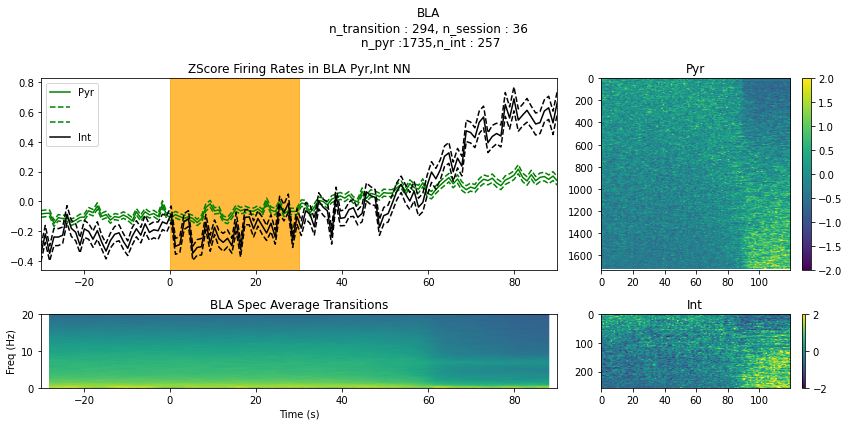

In [59]:
pre = 90
post = 30


BLA_PYR_Filt = (m_REM_NREM_NN["metadata"].Region == "BLA") & (
    m_REM_NREM_NN["metadata"].Type == "Pyr"
)
BLA_INT_Filt = (m_REM_NREM_NN["metadata"].Region == "BLA") & (
    m_REM_NREM_NN["metadata"].Type == "Int"
)

n_transition = m_REM_NREM_NN["n_transitions"]
n_sessions = m_REM_NREM_NN["n_sessions"]
n_pyr = np.sum(BLA_PYR_Filt)
n_int = np.sum(BLA_INT_Filt)

fig, ax = plt.subplot_mosaic(
    """AAC
                               AAC
                               BBD
                    """,
    figsize=[12, 6],
)
plt.sca(ax["A"])
plot_average_transition(
    m_REM_NREM_NN["average_transition"],
    m_REM_NREM_NN["metadata"],
    "BLA",
    "Pyr",
    "g",
    [0, 30],
    pre,post
)
plot_average_transition(
    m_REM_NREM_NN["average_transition"],
    m_REM_NREM_NN["metadata"],
    "BLA",
    "Int",
    "k",
    [0, 30],
    pre,post,
)
plt.legend(["Pyr", "", "", "Int"])
plt.title(f"ZScore Firing Rates in BLA Pyr,Int NN")


plt.sca(ax["B"])
plot_average_spec(
    m_REM_NREM_NN["t_spec"],
    m_REM_NREM_NN["f_spec"],
    np.mean(m_REM_NREM_NN["average_spec"], 0),
)
plt.title("BLA Spec Average Transitions")
plt.xlim(-pre, post)
ax["A"].sharex(ax["B"])
plt.clim(0,10)

plt.sca(ax["C"])
order = np.argsort(
    np.nanmean(m_REM_NREM_NN["average_transition"][BLA_PYR_Filt][:, 89:], 1)
    / np.nanmean(m_REM_NREM_NN["average_transition"][BLA_PYR_Filt][:, 0:89], 1)
)
plt.imshow(
    scipy.stats.zscore(
        m_REM_NREM_NN["average_transition"][BLA_PYR_Filt][order], 1, nan_policy="omit"
    ),
    aspect="auto",
)
plt.clim(-2, 2)
plt.title("Pyr")
plt.colorbar()


plt.sca(ax["D"])
order = np.argsort(
    np.nanmean(m_REM_NREM_NN["average_transition"][BLA_INT_Filt][:, pre-1:], 1)
    / np.nanmean(m_REM_NREM_NN["average_transition"][BLA_INT_Filt][:, 0:pre-1], 1)
)
plt.imshow(
    scipy.stats.zscore(
        m_REM_NREM_NN["average_transition"][BLA_INT_Filt][order], 1, nan_policy="omit"
    ),
    aspect="auto",
)
plt.clim(-2, 2)
plt.title("Int")
plt.colorbar()


plt.suptitle(
    f"BLA\nn_transition : {n_transition}, n_session : {n_sessions}\n n_pyr :{n_pyr},n_int : {n_int}"
)
plt.tight_layout()
plt.savefig("/home/billel/pCloudDrive/IFM/work/Figures/Figures_Gabrielle/Transitions/90-30NN.svg")

/tmp/ipykernel_107688/3974521412.py:60: RuntimeWarning: divide by zero encountered in true_divide
  np.nanmean(m_REM_NREM_NN["average_transition"][BLA_PYR_Filt][:, 30:], 1)
/tmp/ipykernel_107688/3974521412.py:60: RuntimeWarning: invalid value encountered in true_divide
  np.nanmean(m_REM_NREM_NN["average_transition"][BLA_PYR_Filt][:, 30:], 1)


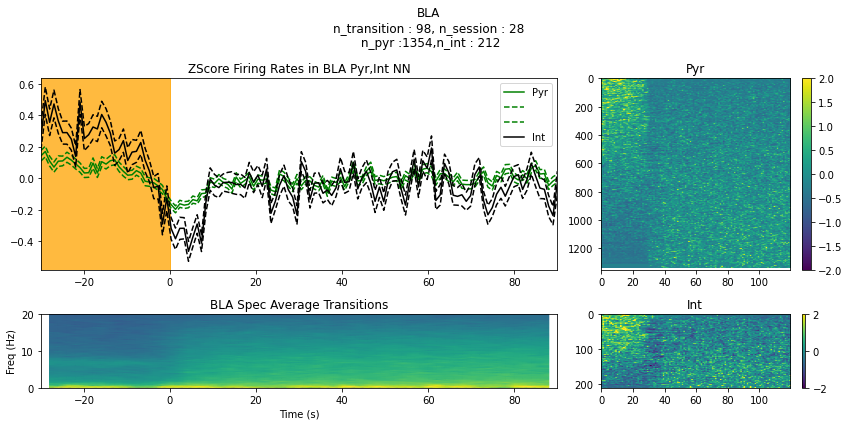

In [63]:
pre = 30
post = 90


BLA_PYR_Filt = (m_REM_NREM_NN["metadata"].Region == "BLA") & (
    m_REM_NREM_NN["metadata"].Type == "Pyr"
)
BLA_INT_Filt = (m_REM_NREM_NN["metadata"].Region == "BLA") & (
    m_REM_NREM_NN["metadata"].Type == "Int"
)

n_transition = m_REM_NREM_NN["n_transitions"]
n_sessions = m_REM_NREM_NN["n_sessions"]
n_pyr = np.sum(BLA_PYR_Filt)
n_int = np.sum(BLA_INT_Filt)

fig, ax = plt.subplot_mosaic(
    """AAC
                               AAC
                               BBD
                    """,
    figsize=[12, 6],
)
plt.sca(ax["A"])
plot_average_transition(
    m_REM_NREM_NN["average_transition"],
    m_REM_NREM_NN["metadata"],
    "BLA",
    "Pyr",
    "g",
    [-30, 0],
    pre,post
)
plot_average_transition(
    m_REM_NREM_NN["average_transition"],
    m_REM_NREM_NN["metadata"],
    "BLA",
    "Int",
    "k",
    [-30, 0],
    pre,post,
)
plt.legend(["Pyr", "", "", "Int"])
plt.title(f"ZScore Firing Rates in BLA Pyr,Int NN")


plt.sca(ax["B"])
plot_average_spec(
    m_REM_NREM_NN["t_spec"],
    m_REM_NREM_NN["f_spec"],
    np.mean(m_REM_NREM_NN["average_spec"], 0),
)
plt.title("BLA Spec Average Transitions")
plt.xlim(-pre, post)
ax["A"].sharex(ax["B"])
plt.clim(0,10)

plt.sca(ax["C"])
order = np.argsort(
    np.nanmean(m_REM_NREM_NN["average_transition"][BLA_PYR_Filt][:, 30:], 1)
    / np.nanmean(m_REM_NREM_NN["average_transition"][BLA_PYR_Filt][:, 0:30], 1)
)
plt.imshow(
    scipy.stats.zscore(
        m_REM_NREM_NN["average_transition"][BLA_PYR_Filt][order], 1, nan_policy="omit"
    ),
    aspect="auto",
)
plt.clim(-2, 2)
plt.title("Pyr")
plt.colorbar()


plt.sca(ax["D"])
order = np.argsort(
    np.nanmean(m_REM_NREM_NN["average_transition"][BLA_INT_Filt][:, pre-1:], 1)
    / np.nanmean(m_REM_NREM_NN["average_transition"][BLA_INT_Filt][:, 0:pre-1], 1)
)
plt.imshow(
    scipy.stats.zscore(
        m_REM_NREM_NN["average_transition"][BLA_INT_Filt][order], 1, nan_policy="omit"
    ),
    aspect="auto",
)
plt.clim(-2, 2)
plt.title("Int")
plt.colorbar()


plt.suptitle(
    f"BLA\nn_transition : {n_transition}, n_session : {n_sessions}\n n_pyr :{n_pyr},n_int : {n_int}"
)
plt.tight_layout()
plt.savefig("/home/billel/pCloudDrive/IFM/work/Figures/Figures_Gabrielle/Transitions/30-90NN.svg")

(90, 30)
Pre set as 90s and post set as 30s
Rat : 8 on day : 6
Working with session Rat08-20130713 @ /mnt/electrophy/Gabrielle/GG-Dataset-Light/Rat08/Rat08-20130713
Data already saved in Numpy format, loading them from here:
Rat08-20130713-neurons.npy
Rat08-20130713-metadata.npy
Computing ['sws', 'Rem'] transitions
Found 21 transitions


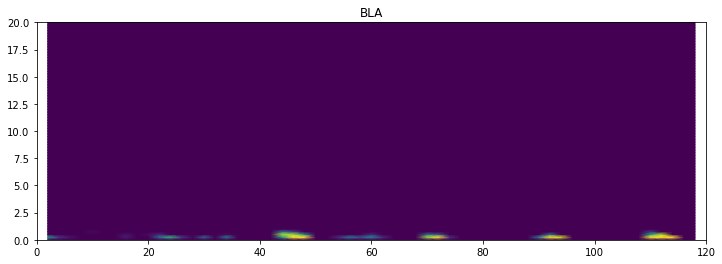

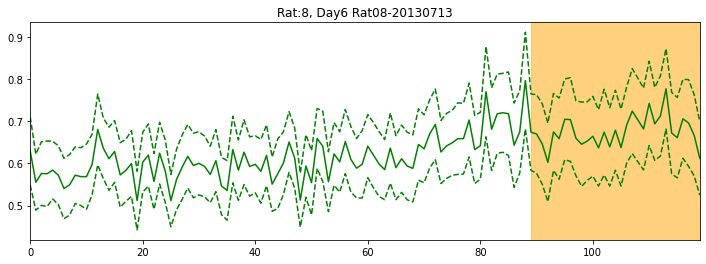

(array([[[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],
 
        [[0, 0, 0, ..., 1, 0, 0],
         [0, 0, 0, ..., 1, 0, 3],
         [0, 0, 0, ..., 3, 0, 1],
         ...,
         [0, 0, 0, ..., 0, 1, 0],
         [0, 0, 0, ..., 0, 0, 1],
         [0, 0, 0, ..., 1, 0, 0]],
 
        [[0, 0, 0, ..., 2, 3, 0],
         [0, 0, 0, ..., 2, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [1, 0, 6, ..., 3, 0, 0],
         [0, 0, 4, ..., 1, 0, 3],
         [0, 0, 3, ..., 2, 0, 1]],
 
        ...,
 
        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 5, 0, 0],
         [0, 0, 0, ..., 2, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],
 
        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 1],
         [2, 0, 0, ..., 0, 0, 0],

In [31]:
args = [90,30]
main_non_normalized('Rat08/Rat08-20130713',*args)